In [122]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [123]:
df = pd.read_parquet("../cleaned/restructured3.parquet")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(['location','timestamp'],inplace=True)

In [124]:
print(df)

                      timestamp  location    lat     lon     P1     P2  \
11387 2018-01-16 16:24:00+00:00         6 -1.259  36.799  17.67   8.60   
11391 2018-01-16 16:27:00+00:00         6 -1.259  36.799  26.33   8.93   
11397 2018-01-16 16:32:00+00:00         6 -1.259  36.799  29.98  11.18   
11399 2018-01-16 16:34:00+00:00         6 -1.259  36.799  26.17  10.37   
11403 2018-01-16 16:37:00+00:00         6 -1.259  36.799  23.23   9.47   
...                         ...       ...    ...     ...    ...    ...   
10280 2023-05-04 09:54:00+00:00      3596 -1.295  36.860  53.00  44.00   
10294 2023-05-04 09:58:00+00:00      3596 -1.295  36.860  44.00  44.00   
10305 2023-05-04 10:02:00+00:00      3596 -1.295  36.860  80.00  67.50   
10318 2023-05-04 10:06:00+00:00      3596 -1.295  36.860  20.00  18.00   
10374 2023-05-04 10:26:00+00:00      3596 -1.295  36.860  40.00  32.00   

       humidity  temperature    P0  
11387       NaN          NaN   NaN  
11391       NaN          NaN   NaN  


# Ingénierie des fonctionnalités

Text(0.5, 1.0, 'Time of day signal')

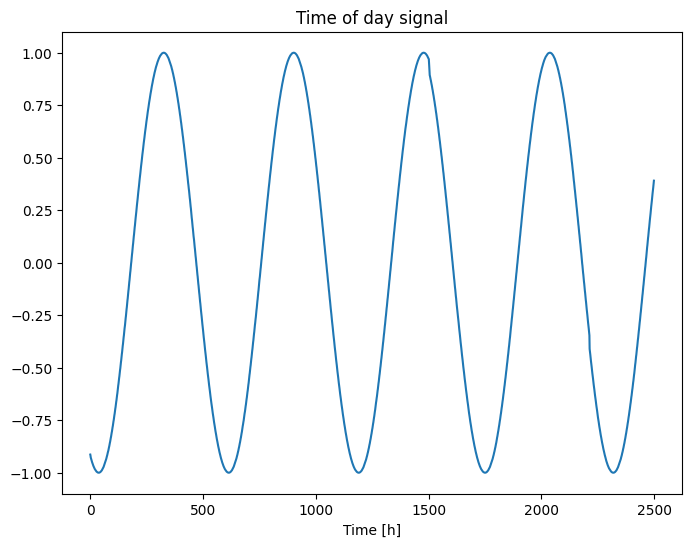

In [125]:
timestamp_s = df['timestamp'].map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:2500])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

# Drop NaN

In [126]:
df_v1 = df.dropna(axis=0)
print(df_v1)

                      timestamp  location    lat     lon     P1     P2  \
91646 2019-04-15 08:57:00+00:00         7 -1.298  36.791  25.60  18.55   
91672 2019-04-15 09:02:00+00:00         7 -1.298  36.791  19.72  14.58   
91697 2019-04-15 09:07:00+00:00         7 -1.298  36.791  27.08  18.53   
91713 2019-04-15 09:10:00+00:00         7 -1.298  36.791   8.40   8.40   
43887 2019-10-08 07:46:00+00:00         7 -1.298  36.791  11.50  10.50   
...                         ...       ...    ...     ...    ...    ...   
10152 2023-05-04 09:12:00+00:00      3596 -1.295  36.860  58.50  52.50   
10215 2023-05-04 09:33:00+00:00      3596 -1.295  36.860  48.00  45.00   
10269 2023-05-04 09:50:00+00:00      3596 -1.295  36.860  29.00  29.00   
10294 2023-05-04 09:58:00+00:00      3596 -1.295  36.860  44.00  44.00   
10305 2023-05-04 10:02:00+00:00      3596 -1.295  36.860  80.00  67.50   

       humidity  temperature     P0   Day sin  Year sin  
91646      72.3         23.9  12.00  0.716302  0.9744

# Temperature

mean_temp = 34.4  ; std_temp =  131.4127460094386


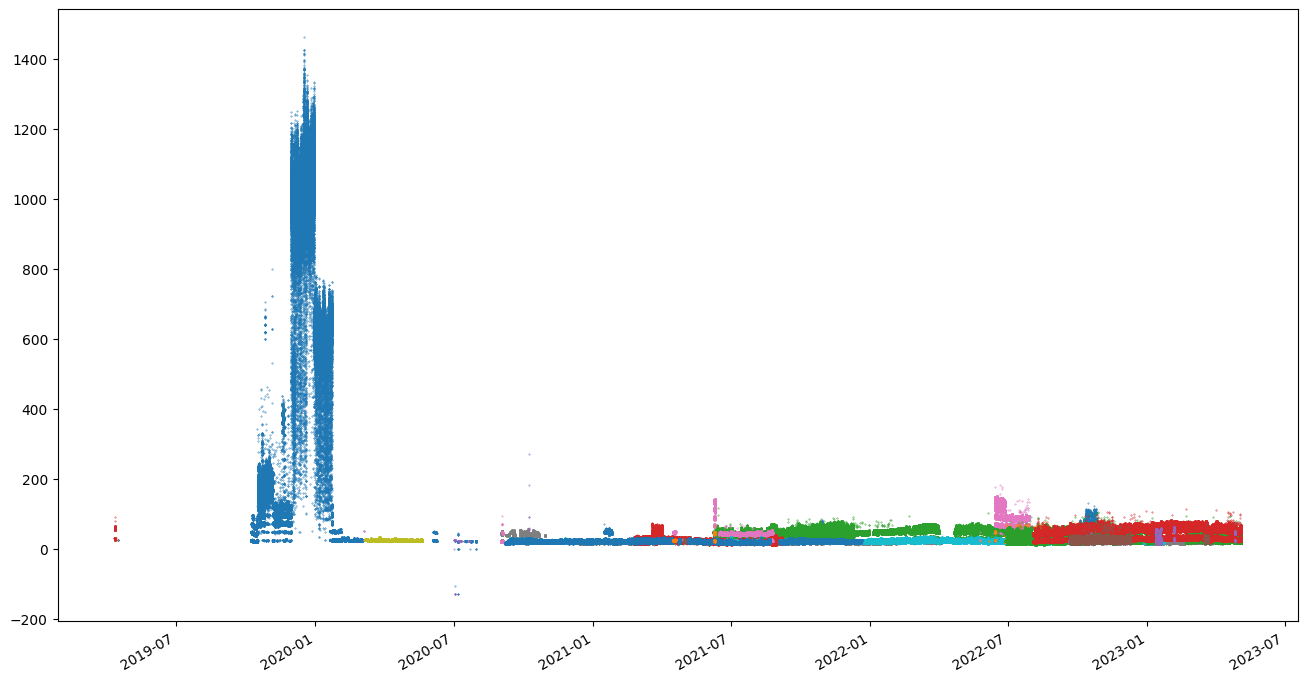

In [127]:
def plot_feature(dataframe, feature):
    mean = np.median(dataframe[feature])
    std = np.std(dataframe[feature])
    print('mean_temp =',mean,' ; std_temp = ',std)

    fig = plt.figure(feature, figsize=(16,9))

    for location in list(set(dataframe['location'])):
        temp = dataframe.loc[dataframe['location'] == location][[feature,'timestamp']]
        plt.scatter(temp.timestamp,temp[feature],s=0.1,label=location)

    plt.gcf().autofmt_xdate()

plot_feature(df_v1, 'temperature')

In [128]:
df_v1['timestamp'] = pd.to_datetime(df_v1['timestamp'])
df_v1['location'] = df_v1['location'].astype(str)

locations = list(set(df_v1.location))

mean_temperature_nairobi = 18.8 # found on internet
location_indicator = pd.DataFrame(columns=['quantity','quality','mean_temperature'],index=locations)

for loc in locations:
    values = df_v1.loc[df_v1['location'] == loc][['temperature']]
    location_indicator.loc[loc,'mean_temperature'] = np.mean(values)
    location_indicator.loc[loc,'quality'] = (abs(np.mean(values)-mean_temperature_nairobi)/mean_temperature_nairobi)*100
    location_indicator.loc[loc,'quantity'] = (len(values)/len(df_v1.temperature))*100

print(location_indicator.sort_values(['quantity'],ascending=False))

C:\Users\marti\AppData\Local\Temp\ipykernel_16916\3034462626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1['timestamp'] = pd.to_datetime(df_v1['timestamp'])
C:\Users\marti\AppData\Local\Temp\ipykernel_16916\3034462626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1['location'] = df_v1['location'].astype(str)


       quantity      quality mean_temperature
18    20.770373   113.823451        40.198809
3573  11.046933    99.008955        37.413684
35    10.083923    10.113821        20.701398
33    10.056086     2.656167        19.299359
46     8.813121   101.703881         37.92033
3576   7.548287   145.943348        46.237349
7      7.336082  1715.776034       341.365894
67     6.168767   215.714636        59.354352
78     4.329384    115.58176        40.529371
77     3.049736    19.747949        22.512614
3580   2.945898    30.419233        24.518816
3505   2.871302     24.44098        23.394904
3522   1.433615     4.678712        19.679598
74     1.419749    31.435731        24.709917
76     1.370006    11.899059        21.037023
3596   0.269564    50.134035        28.225199
34     0.198689    28.790504        24.212615
3579   0.111736    83.458332        34.490167
37     0.098748    23.914046        23.295841
60     0.038088    25.606922        23.614101
27     0.018395     6.750447      

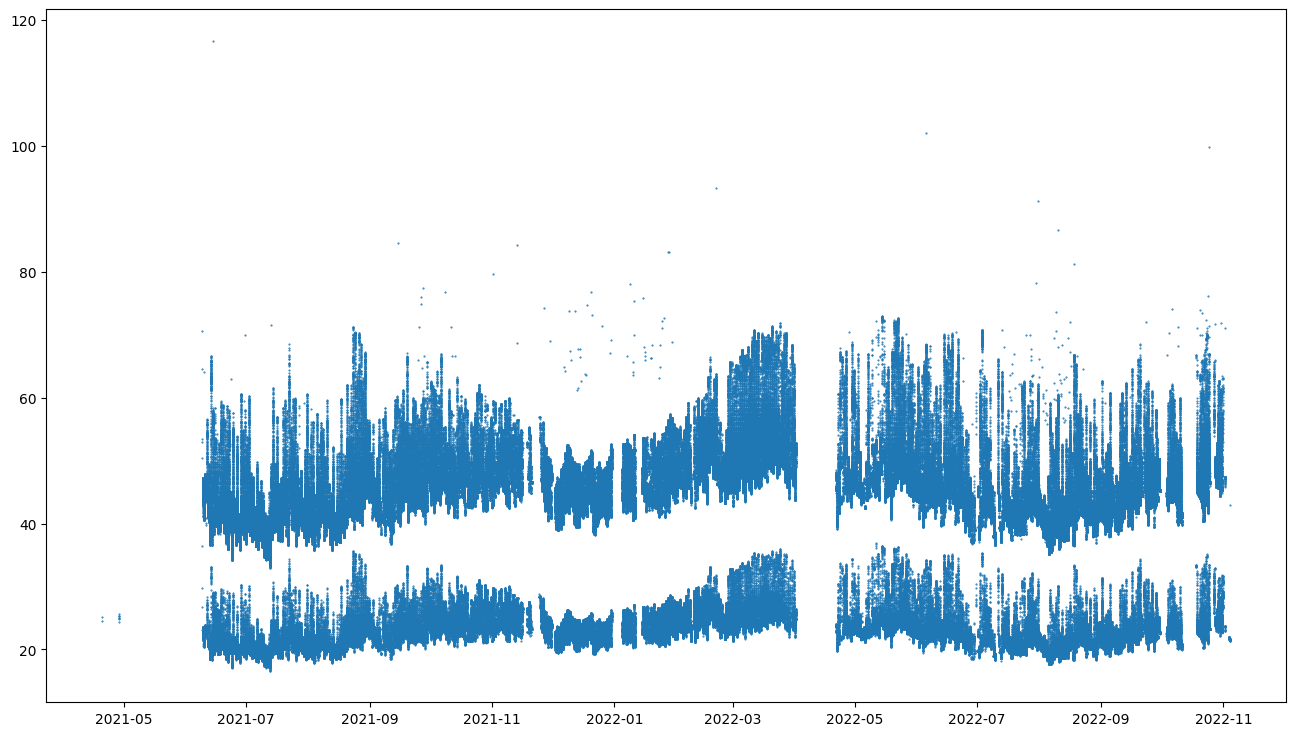

In [129]:
fig = plt.figure('temperature', figsize=(16,9))

temperature = df_v1.loc[df_v1['location'] == '18'][['temperature','timestamp']]
plt.scatter(temperature.timestamp,temperature.temperature,s=0.25)

## Interprétation

Pour plusieurs locations on remarque, deux tracés de mesures. On a aussi des locations avec beaucoup de valeurs aberrantes ce qui ce retrouve dans la moyenne (ex: location 7).

Hypothèse 1 : Etant donné que la moyenne des température sur une année de nairobi est à peu près de 20°C (source : internet), on considérera que le tracé du haut comme des données erronées. 

Nous allons donc :
=> Enlever les données erronées en coupant les températures au dela de 35°C ce qui est une méthode simple et qui semble bien séparer les deux tracés sans supprimer trop de bons échantillons et sans laisser trop de mauvais échantillons.

=> supprimer les locations qui représentent peu de valeurs qui semblent incohérentes 

mean_temp = 21.5  ; std_temp =  4.744733956361065


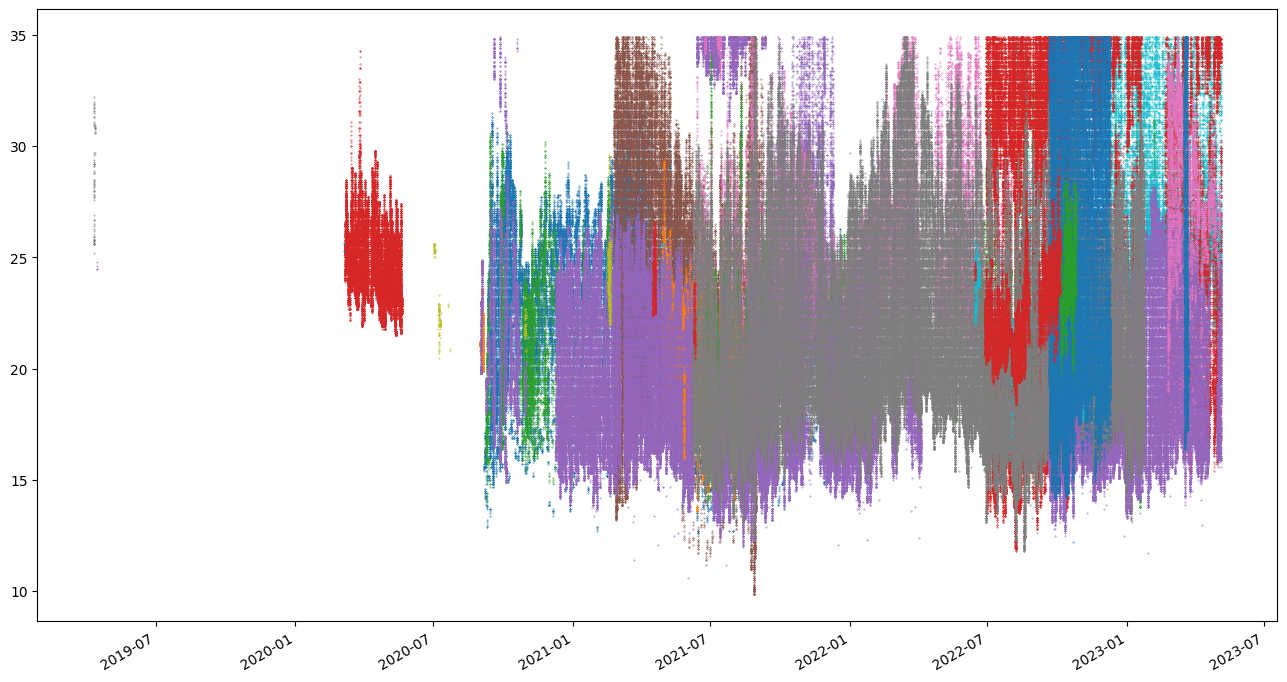

In [130]:
df_v2 = df_v1.loc[(((df_v1['temperature'] < 35) & (df_v1['temperature'] > 0)) & (df_v1['location'] != '7'))]

plot_feature(df_v2, 'temperature')

# Humidity

In [131]:
print(df_v2)

                      timestamp location    lat     lon    P1    P2  humidity  \
50407 2021-04-20 09:34:00+00:00       18 -1.292  36.821  10.0   9.0      63.7   
50412 2021-04-20 09:37:00+00:00       18 -1.292  36.821   8.0   8.0      63.1   
67637 2021-04-28 10:37:00+00:00       18 -1.292  36.821   5.5   5.5      64.3   
67642 2021-04-28 10:39:00+00:00       18 -1.292  36.821   4.6   4.0      63.2   
67647 2021-04-28 10:42:00+00:00       18 -1.292  36.821   6.4   6.4      66.8   
...                         ...      ...    ...     ...   ...   ...       ...   
10152 2023-05-04 09:12:00+00:00     3596 -1.295  36.860  58.5  52.5      81.4   
10215 2023-05-04 09:33:00+00:00     3596 -1.295  36.860  48.0  45.0      80.2   
10269 2023-05-04 09:50:00+00:00     3596 -1.295  36.860  29.0  29.0      78.7   
10294 2023-05-04 09:58:00+00:00     3596 -1.295  36.860  44.0  44.0      77.1   
10305 2023-05-04 10:02:00+00:00     3596 -1.295  36.860  80.0  67.5      76.4   

       temperature    P0   

mean_temp = 84.1  ; std_temp =  31.657660155411982


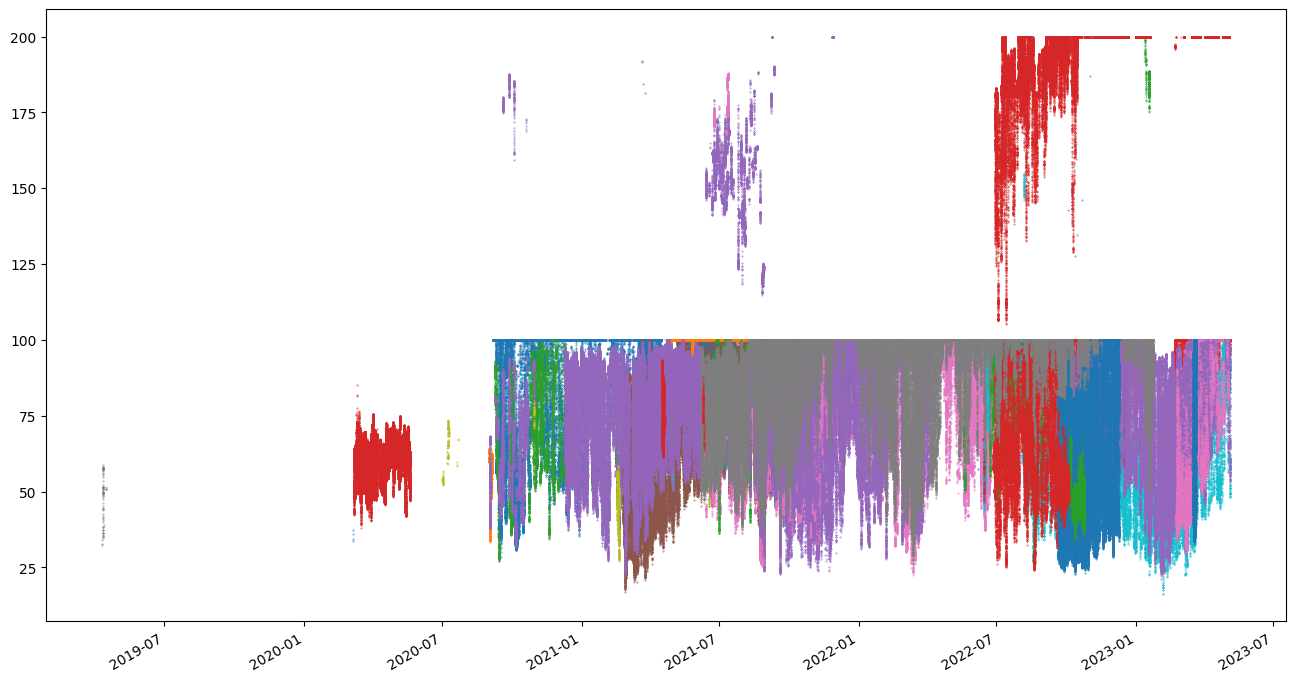

In [132]:
plot_feature(df_v2,'humidity')

## Interprétation

Une humidité relative supérieur à 100% est une valeur erronée. Il semble que les valeurs erronées pour la température et l'humidité se produise en même temps

Nous allons donc supprimer ces valeurs


mean_temp = 81.4  ; std_temp =  20.122804359077254


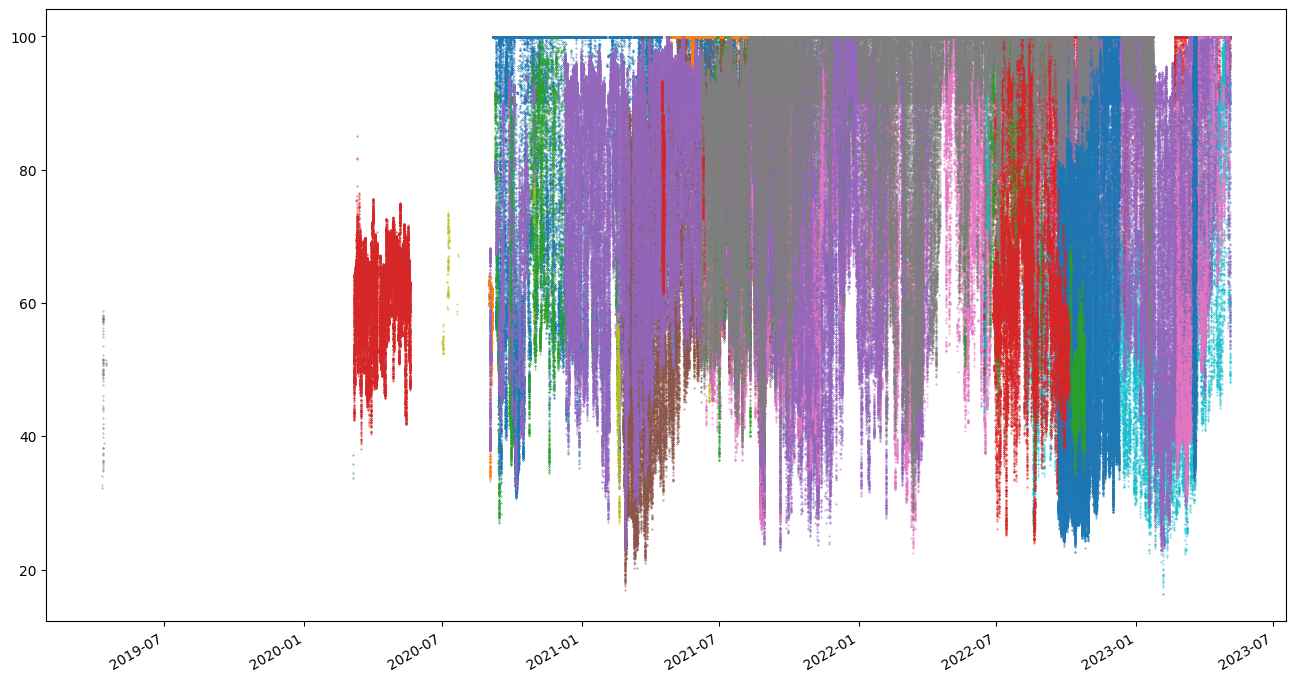

In [134]:
df_v3 = df_v2.loc[df_v2['humidity'] <= 100]

plot_feature(df_v3,'humidity')

# Final Dataset

Surement quelques valeurs incohérentes mais pas vraiment de moyen de les retirer. 

Taille final : 1.326.988 échantillons soit 16.6% des échantillons de départ


In [135]:
print(df_v3)

                      timestamp location    lat     lon    P1    P2  humidity  \
50407 2021-04-20 09:34:00+00:00       18 -1.292  36.821  10.0   9.0      63.7   
50412 2021-04-20 09:37:00+00:00       18 -1.292  36.821   8.0   8.0      63.1   
67637 2021-04-28 10:37:00+00:00       18 -1.292  36.821   5.5   5.5      64.3   
67642 2021-04-28 10:39:00+00:00       18 -1.292  36.821   4.6   4.0      63.2   
67647 2021-04-28 10:42:00+00:00       18 -1.292  36.821   6.4   6.4      66.8   
...                         ...      ...    ...     ...   ...   ...       ...   
10152 2023-05-04 09:12:00+00:00     3596 -1.295  36.860  58.5  52.5      81.4   
10215 2023-05-04 09:33:00+00:00     3596 -1.295  36.860  48.0  45.0      80.2   
10269 2023-05-04 09:50:00+00:00     3596 -1.295  36.860  29.0  29.0      78.7   
10294 2023-05-04 09:58:00+00:00     3596 -1.295  36.860  44.0  44.0      77.1   
10305 2023-05-04 10:02:00+00:00     3596 -1.295  36.860  80.0  67.5      76.4   

       temperature    P0   

mean_temp = 21.2  ; std_temp =  4.157910080341311


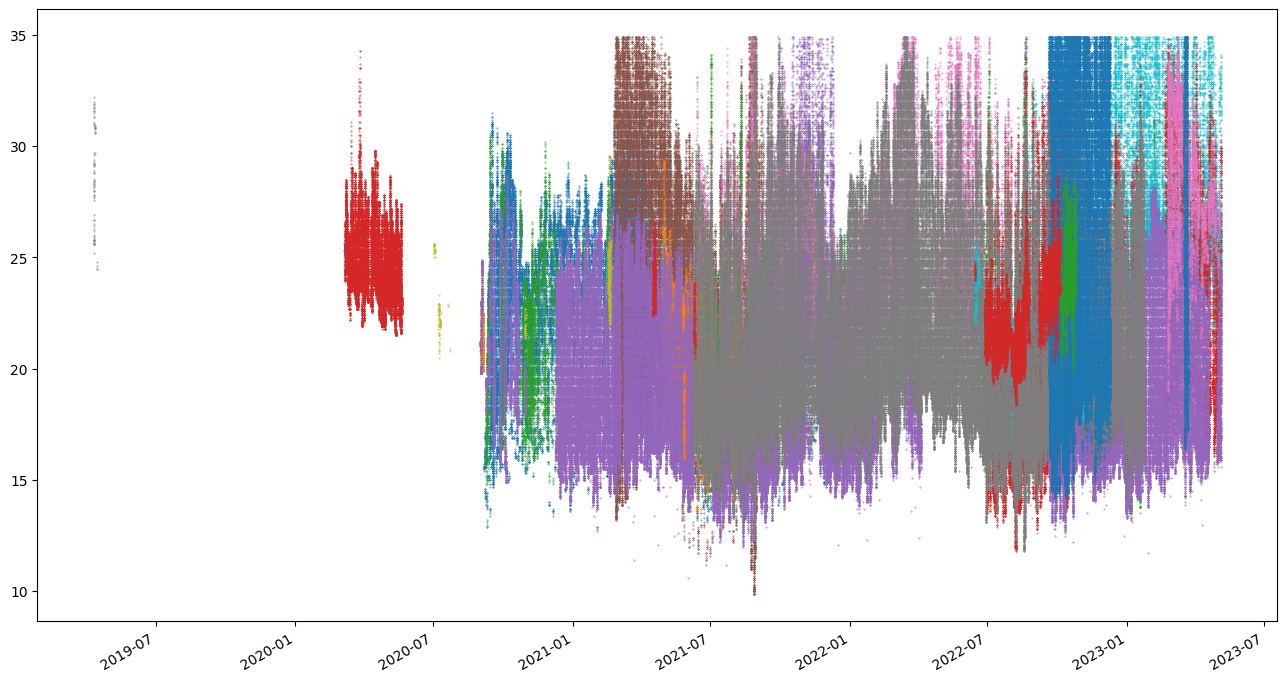

In [136]:
plot_feature(df_v3,'temperature')

In [138]:
df_v3.to_parquet('../final_data/final_data_v1.parquet')